## <Big> PREDICTING CREDIT CARD SPEND/ KEY DRIVERS

## Business Problem:

One of the global banks would like to understand what factors driving credit card spend are. The bank wants to use these insights to calculate credit limit. In order to solve the problem, the bank conducted survey of 5000 customers and collected data.
The objective of this case study is to understand what's driving the total spend (Primary Card + Secondary card). Given the factors, predict credit limit for the new applicants.


## Data Availability:

- Data for the case are available in xlsx format(Data Set.xlxs).
- The data have been provided for 5000 customers.
- Detailed data dictionary has been provided for understanding the data in the data.
- Data is encoded in the numerical format to reduce the size of the data however some of the variables are categorical. You can  find the details in the data dictionary

In [1]:
# Lets load the neccesary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

import pandas_profiling as pp


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from patsy import dmatrices
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

## Creating an Excel File for output - Regression Output.xlsx

In [2]:
writer = pd.ExcelWriter('Regression Output.xlsx')

### <big> Importing the data sets

In [3]:
credit=pd.read_excel('Data Set.xlsx')
credit.head(2)

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,3964-QJWTRG-NPN,1,2.0,1,20,2,September,15,3,1,...,0,0,0,1,1,0,0,0,1,0
1,0648-AIPJSP-UVM,5,5.0,0,22,2,May,17,4,2,...,1,1,1,1,1,1,1,0,0,0


<big><big> <Strong> Generating the Pandas Profiling Report 

In [4]:
#report= pp.ProfileReport(credit)
#report.to_file(outputfile = 'profilereport_Credit_1.html')

<Big> <stong> Data is all messed up, ctegorical not stored as objects, we must sepearate out categorical and numerical data properly to proceed

<Strong> <big> df.info Method also tells the same

In [5]:
print('_'*45)
print(credit.info())
print('_'*45)
print('\nCredit Card Data shape:',credit.shape)

_____________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 130 entries, custid to response_03
dtypes: float64(31), int64(97), object(2)
memory usage: 5.0+ MB
None
_____________________________________________

Credit Card Data shape: (5000, 130)


## <big> Numerical and categorical Fixing as per data Dcitionary starts

### First droping custid as it is not at all helpful for us in the analysis

In [6]:
credit.drop('custid',axis=1,inplace=True)

<Strong><big> Creating a Categorical List to Contain all categorical variables

In [7]:
cat_var=['region','townsize','gender','agecat','birthmonth','edcat','jobcat','union',
'employ','empcat','retire','inccat','default','jobsat','marital','spousedcat',
'homeown','hometype','address','addresscat','cars','carown','cartype',
'carcatvalue','carbought','carbuy','commute','commutecat','commutecar','commutemotorcycle',
'commutecarpool','commutebus','commuterail','commutepublic','commutebike','commutewalk',
'commutenonmotor','telecommute','reason','polview','polparty','polcontrib','vote','card',
'cardtype','cardbenefit','cardfee','cardtenure','cardtenurecat','card2','card2type',
'card2benefit','card2fee','card2tenure','card2tenurecat','active','bfast','churn','tollfree',
'equip','callcard','wireless','multline','voice','pager','internet','callid','callwait','forward',
'confer','ebill','owntv','ownvcr','owndvd','owncd','ownpda','ownpc','ownipod','owngame','ownfax','news',
'response_01','response_02','response_03']

## Creating a  List to Contain all numerical variables as well
<big> <strong> We have excel file that has data dictionary to help us explicitly with categorical variables 
1. It has categorical varaiables 
2. It has all vars 
3. [All var] - [cat var] = [Numerical Var]
    
<strong> A loop will help to seperate numerical from mised variables-

In [8]:
numerical_var=[]
for i in credit.columns:
    if i not in cat_var:
        numerical_var.append(i)
print(numerical_var)

['age', 'ed', 'income', 'lninc', 'debtinc', 'creddebt', 'lncreddebt', 'othdebt', 'lnothdebt', 'spoused', 'reside', 'pets', 'pets_cats', 'pets_dogs', 'pets_birds', 'pets_reptiles', 'pets_small', 'pets_saltfish', 'pets_freshfish', 'carvalue', 'commutetime', 'cardspent', 'card2spent', 'tenure', 'longmon', 'lnlongmon', 'longten', 'lnlongten', 'tollmon', 'lntollmon', 'tollten', 'lntollten', 'equipmon', 'lnequipmon', 'equipten', 'lnequipten', 'cardmon', 'lncardmon', 'cardten', 'lncardten', 'wiremon', 'lnwiremon', 'wireten', 'lnwireten', 'hourstv']


In [9]:
print ('Number of numerical variables   :-  {}'.format(len(numerical_var)))
print ('Number of categorical variables :-  {}'.format(len(cat_var)))

Number of numerical variables   :-  45
Number of categorical variables :-  84


## WRITING UDFS
<big> Description of UDF Tells its functionality

In [10]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

# Create Data audit Report for categorical variables

def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [11]:
def list_update(var):
    if var in cat_var:
        cat_var.remove(var)
    elif var in numerical_var:
        numerical_var.remove(var)
    else:
        print("This variable is not present in either of the list.")
        
# Function to drop all the vaariable in given list from main dataset i.e "credit".
def list_drop(inp):
    for var in inp:
        list_update(var)
        credit.drop(var,axis=1,inplace=True)
        credit_conti_var=credit.loc[:, numerical_var]
        credit_cat_var=credit.loc[:, cat_var]

In [12]:
# An utility function to create dummy variable

def create_dummies( credits_cat, colname ):
    col_dummies = pd.get_dummies(credits_cat[colname], prefix=colname)
    col_dummies.drop(col_dummies.columns[0], axis=1, inplace=True)
    credits_cat = pd.concat([credits_cat, col_dummies], axis=1)
    credits_cat.drop( colname, axis = 1, inplace = True )
    return credits_cat

### <big> Card Spent 1 and 2 can be combined 
###  <big> A quick histogram Plot will help to see its distribution

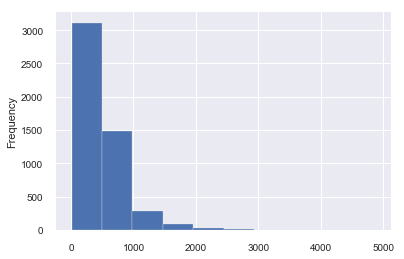

In [13]:
credit['total_spent']=credit['cardspent']+credit['card2spent']
credit['total_spent'].plot(kind='hist')

### It is highly skewed, log can take care of it to some extentent

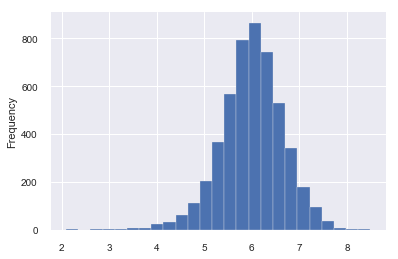

In [14]:
credit['total_spent_ln']=np.log(credit['total_spent'])
credit['total_spent_ln'].plot(kind='hist',bins=25)

In [15]:
list_drop(['total_spent','cardspent','card2spent'])
numerical_var.append('total_spent_ln')

This variable is not present in either of the list.


### Missing Values Inspection

In [16]:
credit.isnull().sum().value_counts()

0       113
2         3
3296      2
3656      2
2622      2
3         2
1         2
1422      1
1419      1
dtype: int64

#### -There are missing values in the data: Let us inspect for variables where missing values are more than 25%

In [17]:
credit_conti_var=credit.loc[:, numerical_var]
Missing_values=pd.DataFrame(credit_conti_var.apply(continuous_var_summary).T.round(1)['NMISS']/5000*100)
M_V=Missing_values[Missing_values['NMISS']>25]
M_V

,NMISS
lntollmon,52.44
lntollten,52.44
lnequipmon,65.92
lnequipten,65.92
lncardmon,28.38
lncardten,28.44
lnwiremon,73.12
lnwireten,73.12


In [18]:
M_V.to_excel(writer, 'High_Miss_Values', index=True)

In [19]:
list_drop(M_V.index)
credit_conti_var.drop(M_V.index,axis=1,inplace=True)

In [20]:
credit.isna().sum().value_counts()

0    113
2      3
3      2
1      2
dtype: int64

### Numerical variable summary

In [21]:
num_summary=credit_conti_var.apply(continuous_var_summary).T.round(1)
num_summary.to_excel(writer,sheet_name = 'Numerical Variable Summary', index=True)
num_summary.head()

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
age,5000.0,0.0,235128.0,47.0,47.0,17.8,315.8,18.0,18.0,20.0,23.0,31.0,47.0,62.0,72.0,76.0,79.0,79.0
ed,5000.0,0.0,72715.0,14.5,14.0,3.3,10.8,6.0,8.0,9.0,10.0,12.0,14.0,17.0,19.0,20.0,21.0,23.0
income,5000.0,0.0,273798.0,54.8,38.0,55.4,3066.7,9.0,9.0,13.0,16.0,24.0,38.0,67.0,109.1,147.0,272.0,1073.0
lninc,5000.0,0.0,18499.5,3.7,3.6,0.7,0.6,2.2,2.2,2.6,2.8,3.2,3.6,4.2,4.7,5.0,5.6,7.0
debtinc,5000.0,0.0,49770.8,10.0,8.8,6.4,41.0,0.0,0.7,1.9,2.8,5.1,8.8,13.6,18.6,22.2,29.2,43.1


## Generating Pandas profile Report to check for correlations and other problems

In [22]:
#report_2= pp.ProfileReport(credit)
#report_2.to_file(outputfile = 'profilereport_Credit_2.html')

**From the above profile report, we found some highly correlated variables...**

   -addresscat is highly correlated with address (ρ = 0.9235209425)	Rejected  
   -agecat is highly correlated with age (ρ = 0.9698787511)	Rejected  
   -card2tenurecat is highly correlated with card2tenure (ρ = 0.9243911464)	Rejected  
   -cardtenure is highly correlated with card2tenure (ρ = 0.9629752995)	Rejected  
   -cardtenurecat is highly correlated with card2tenurecat (ρ = 0.9243052909) Rejected  
   -commutecat is highly correlated with commute (ρ = 0.981171323)	Rejected  
   -edcat is highly correlated with ed (ρ = 0.9638959094)	Rejected  
   -equipmon is highly correlated with equip (ρ = 0.9405054161)	Rejected  
   -lninc is highly correlated with inccat (ρ = 0.9487921563)	Rejected   
   -lnlongten is highly correlated with lnlongmon (ρ = 0.9217106724) Rejected   
   -longten is highly correlated with longmon (ρ = 0.9856982538)	Rejected   
   -spoused is highly correlated with marital (ρ = 0.9557686636)	Rejected   
   -spousedcat is highly correlated with spoused (ρ = 0.9840285958)	Rejected   
   -tenure is highly correlated with lnlongten (ρ = 0.9268535788)	Rejected  


**So we must drop these variables**  
     ['addresscat','agecat','card2tenure','commutecat','edcat','equipmon','inccat','lnlongten',
            'longten', 'spoused','spousedcat','tenure']

In [23]:
# dropping only numerical variables that are correlated, retianing categorical variables for dummy creation

drop_col=['addresscat','agecat','cardtenurecat','card2tenurecat','cardtenure','commutecat','edcat','equipmon','inccat','lnlongten',
            'longten', 'spoused','spousedcat','tenure','tollmon','wiremon']
drop_list=[]
for var in drop_col:
    if var in numerical_var:
        list_drop([var])
    else:
        print(var)
        drop_list.append(var)    

addresscat
agecat
cardtenurecat
card2tenurecat
cardtenure
commutecat
edcat
inccat
spousedcat


### Outlier Treatment

In [24]:
credit[numerical_var]=credit[numerical_var].apply(lambda x: x.clip(lower = x.dropna().quantile(0.01), upper = x.quantile(0.99)))

In [25]:
credit.to_excel(writer,'Outlier_Treatment',index=True)

### Missing Value Imputation

In [26]:
credit[cat_var]=credit[cat_var].apply(lambda x: x.fillna(x.mode()[0]))

sum(credit[cat_var].isna().sum())

0

In [27]:
credit[numerical_var]=credit[numerical_var].apply(lambda x: x.fillna(x.median()))

sum(credit[numerical_var].isna().sum())

0

In [28]:
credit.to_excel(writer,'Missing Value Treated',index=True)

### Converting categorical columns to numerical ones and Creating Dummies

In [29]:
from time import strptime
def tomonth(x):
    month_number=strptime(x, '%B').tm_mon
    return month_number

credit['birthmonth']=credit['birthmonth'].map(lambda x: tomonth(x))

In [30]:
# converting only these variables to dummies because remaning variables are in boolean form, 
# I dont think making dummies out of boolean data makes sense

cat_to_dum=['region', 'townsize','gender','agecat','edcat','empcat','inccat','jobsat','spousedcat',
         'hometype','addresscat','cars','carown','cartype','carcatvalue',
         'carbought','commutecat','reason','polview','card','cardtype','cardbenefit',
         'cardtenurecat','card2','card2type','card2benefit','card2tenurecat',
         'bfast','internet']

credit_cat=credit.loc[:,cat_to_dum]
for var in cat_to_dum:
    credit_cat.loc[:,var]=credit_cat.loc[:,var].astype('category')
    credit_cat=create_dummies(credit_cat, var)

In [31]:
credit_cat.shape

(5000, 106)

In [32]:
list_drop(cat_to_dum)

In [33]:
credit=pd.concat([credit,credit_cat],axis=1)
credit.shape

(5000, 190)

#### log of all these variables is there in the data - we can drop these 
'income','othdebt','creddebt'  

In [34]:
list_drop(['income','othdebt','creddebt'])

## Splitting Training and Testing Data

In [35]:
#Splitting the data
feature_columns = credit.columns.difference( ['total_spent_ln'] )
train_X, test_X, train_y, test_y = train_test_split(credit[feature_columns],
                                                  credit['total_spent_ln'],
                                                  test_size=0.3,random_state=123)
                                                  
print (len( train_X ))
print (len (train_y))
print (len( test_X))
print (len( test_y))
print (credit.shape)

3500
3500
1500
1500
(5000, 187)


## Random Forest For Feature selection and importance

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [37]:
param_grid={'n_estimators':np.arange(10,25)}

In [38]:
tree=GridSearchCV(RandomForestRegressor(oob_score=False,warm_start=True),param_grid,cv=2)
tree.fit(train_X,train_y)  

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=True),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [39]:
tree.best_params_

{'n_estimators': 23}

### Making model according to best parameters:

In [40]:
clf_rf = RandomForestRegressor(oob_score=True,n_estimators=23)
clf_rf.fit( train_X, train_y)

C:\Users\nikhi\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=23, n_jobs=None,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [41]:
clf_rf.oob_score_

0.12793769550444933

In [42]:
from sklearn import metrics

In [43]:
ce=pd.DataFrame(clf_rf.feature_importances_, index=train_X.columns, columns={'Coefficients' : 0})
ce.sort_values('Coefficients',ascending=False,inplace=True)
ce.to_csv('rf_feature_imp')
ce.head(10)

,Coefficients
lninc,0.200917
lnothdebt,0.031236
lncreddebt,0.030060
carvalue,0.027057
debtinc,0.023290
card_3,0.022987
card_2,0.022433
commutetime,0.021916
hourstv,0.021182
cardmon,0.019925


In [44]:
top_features=list(ce.index[0:40])

In [45]:
# Create data frame with selected features
top_features.append('total_spent_ln')
rf_df=credit[top_features]
rf_df.head()

,lninc,lnothdebt,lncreddebt,carvalue,debtinc,card_3,card_2,commutetime,hourstv,cardmon,...,pets_freshfish,wireten,card2_3,pets_cats,gender_1,internet_4,cardbenefit_3,carbuy,card2_4,total_spent_ln
0,3.433987,0.806516,0.183079,14.3,11.1,1,0,22.0,13,14.25,...,0,0.00,0,0,1,0,0,0,0,5.007029
1,2.708050,0.449788,0.200505,6.8,18.6,0,1,29.0,18,16.00,...,6,1683.55,0,0,0,1,0,0,1,4.350794
2,3.555348,0.930738,-0.074056,18.8,9.9,0,1,24.0,21,23.00,...,0,0.00,0,2,1,0,0,1,1,5.886021
3,2.995732,0.110826,-3.401690,8.7,5.7,0,1,38.0,26,21.00,...,0,0.00,1,0,0,0,0,1,0,5.884464
4,3.135494,-1.735336,-1.538705,10.6,1.7,0,0,32.0,27,17.25,...,0,410.80,0,0,0,0,0,1,0,6.230147


## Taking Care of multicolinearlity with the help of VIF, dropping features having VIF>9

In [47]:
top_features=list(ce.index[0:40])
top_features.append('total_spent_ln')
rf_df=credit[top_features]
features = "+".join(top_features)
features

'lninc+lnothdebt+lncreddebt+carvalue+debtinc+card_3+card_2+commutetime+hourstv+cardmon+card_4+address+birthmonth+age+cardten+employ+ed+longmon+reason_2+lnlongmon+tollten+equipten+pets+card2tenure+cardtenure+card_5+jobcat+pets_dogs+commute+reside+card2_2+pets_freshfish+wireten+card2_3+pets_cats+gender_1+internet_4+cardbenefit_3+carbuy+card2_4+total_spent_ln'

In [48]:
y, X = dmatrices('total_spent_ln~ '+features,rf_df, return_type='dataframe')

In [49]:
# For each X, calculate VIF and save in the dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.sort_values(by=['VIF Factor'],ascending=False).head(10)

,VIF Factor,features
0,436.532791,Intercept
25,16.785446,cardtenure
24,15.742719,card2tenure
23,13.289402,pets
32,11.848761,pets_freshfish
15,7.971251,cardten
1,7.699189,lninc
20,6.992044,lnlongmon
2,6.096216,lnothdebt
18,5.456101,longmon


In [50]:
vif1=vif[vif['VIF Factor']>9.9].reset_index().loc[:,['features']]
vif1.drop([0],axis=0,inplace=True)
drop_vars= vif1["features"].tolist()
drop_vars

['pets', 'card2tenure', 'cardtenure', 'pets_freshfish']

In [51]:
rf_df.drop(drop_vars,axis=1,inplace=True)

C:\Users\nikhi\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [52]:
rf_df.shape

(5000, 37)

In [53]:
# Dropping p values greater than 5% one by one

In [149]:
feature_columns=rf_df.columns.difference(['total_spent_ln', 'pets_cats', 'reside', 'cardbenefit_3', 'pets_dogs','cardten',
                                           'lnothdebt', 'wireten', 'commute', 'birthmonth' , 'commutetime', 'debtinc',
                                          'hourstv', 'lnlongmon', 'longmon', 'tollten' , 'carvalue', 'employ', 'carbuy',
                                          'address','cardmon', 'internet_4', 'lncreddebt'
                                         ])

In [150]:
train_X,test_X,train_y,test_y=train_test_split(rf_df[feature_columns],
                                              rf_df['total_spent_ln'],
                                               test_size=.25,
                                               random_state=123)

In [151]:
train_X = sm.add_constant(train_X)
test_X=sm.add_constant(test_X)
lm=sm.OLS(train_y,train_X).fit()

In [152]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:         total_spent_ln   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     136.6
Date:                Sat, 30 Nov 2019   Prob (F-statistic):          4.59e-322
Time:                        17:26:33   Log-Likelihood:                -2953.2
No. Observations:                3750   AIC:                             5936.
Df Residuals:                    3735   BIC:                             6030.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6067      0.073     77.178      0.0

In [160]:
f=open('model Summary.csv','w')
f.write(lm.summary().as_csv())
#f.write(lm.summary().as_latex())
f.close()

In [161]:
lm.pvalues.sort_values(ascending=False)

equipten     3.524570e-02
ed           1.826491e-02
jobcat       1.958801e-03
gender_1     1.104457e-03
age          1.471986e-04
reason_2     2.069387e-14
card_5       1.191191e-24
card2_4      1.959638e-29
card2_3      8.075012e-30
card2_2      1.639633e-31
card_2       2.171067e-85
card_3       2.918801e-89
card_4      6.293152e-107
lninc       7.969760e-171
const        0.000000e+00
dtype: float64

In [162]:
print('Parameters:', lm.params) 
print('R2: ', lm.rsquared) 

Parameters: const       5.606744
age        -0.001906
card2_2    -0.304277
card2_3    -0.293193
card2_4    -0.318518
card_2     -0.575647
card_3     -0.589677
card_4     -0.658838
card_5     -0.486648
ed         -0.007198
equipten    0.000022
gender_1   -0.057160
jobcat     -0.015666
lninc       0.364855
reason_2    0.272603
dtype: float64
R2:  0.33861001736047247


## Model Evaluation using MSE, MAE, RMSE 

In [163]:
test_pred=lm.predict(test_X)
train_pred=lm.predict(train_X)

print('MSE for Test:',metrics.mean_squared_error(test_y,test_pred))
print('MSE for Train:',metrics.mean_squared_error(train_y,train_pred))

MSE for Test: 0.2618683879260483
MSE for Train: 0.28285672533577516


In [164]:
print ('MAE:', metrics.mean_absolute_error(test_y, test_pred))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(test_y, test_pred)))

MAE: 0.4027532606201884
RMSE: 0.5117307768016774


## Checking if residuals are normally distributed

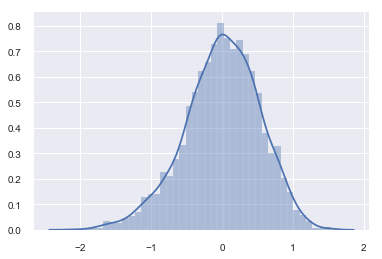

In [165]:
residuals=train_y-train_pred
sns.distplot(residuals)

## Predicting Sales 

In [166]:
rf_df=rf_df[feature_columns]
rf_df=sm.add_constant(rf_df)
rf_df.head()

C:\Users\nikhi\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,const,age,card2_2,card2_3,card2_4,card_2,card_3,card_4,card_5,ed,equipten,gender_1,jobcat,lninc,reason_2
0,1.0,20,0,0,0,0,1,0,0,15,126.1,1,1,3.433987,0
1,1.0,22,0,0,1,1,0,0,0,17,1975.0,0,2,2.708050,0
2,1.0,67,0,0,1,1,0,0,0,14,0.0,1,2,3.555348,1
3,1.0,23,0,1,0,1,0,0,0,16,0.0,0,2,2.995732,0
4,1.0,26,0,0,0,0,0,1,0,16,0.0,0,2,3.135494,0


In [167]:
pred_tot_spend= pd.DataFrame(np.exp(lm.predict(rf_df)), columns= {"pred_tot_spend": 0})
pred_tot_spend.head()

,pred_tot_spend
0,425.769583
1,257.066594
2,389.718235
3,281.627110
4,363.529868


In [168]:
credit_orig=pd.read_excel('Data Set.xlsx')

In [169]:
#Adding final prediction column to original test file
  
Submission = pd.concat([credit_orig, pred_tot_spend], axis=1)

Submission.head()

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,...,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03,pred_tot_spend
0,3964-QJWTRG-NPN,1,2.0,1,20,2,September,15,3,1,...,0,0,1,1,0,0,0,1,0,425.769583
1,0648-AIPJSP-UVM,5,5.0,0,22,2,May,17,4,2,...,1,1,1,1,1,1,0,0,0,257.066594
2,5195-TLUDJE-HVO,3,4.0,1,67,6,June,14,2,2,...,0,0,0,0,0,1,0,0,0,389.718235
3,4459-VLPQUH-3OL,4,3.0,0,23,2,May,16,3,2,...,0,1,1,1,0,1,1,0,0,281.627110
4,8158-SMTQFB-CNO,2,2.0,0,26,3,July,16,3,2,...,0,1,0,1,0,0,0,1,0,363.529868


In [170]:
Submission.to_excel(writer, "Predictions", index=True)
Submission.to_csv("Predictions")

### Buisness Validation Through Decile Ananlysis

In [171]:
train=pd.concat([train_X,train_y],axis=1)
test=pd.concat([test_X,test_y],axis=1)
train=sm.add_constant(train)
train['pred_tot_spend'] = lm.predict(train_X)
test=sm.add_constant(test)
test['pred_tot_spend'] = lm.predict(test_X)

In [172]:
# create the 10 groups in the data
train['Deciles'] = pd.qcut(train['pred_tot_spend'], 10, labels = False)

# Decile Analysis for train data
Predicted_avg = train[['Deciles', 'pred_tot_spend']].groupby(train.Deciles).mean().sort_index(ascending = False)['pred_tot_spend']
Actual_avg = train[['Deciles', 'total_spent_ln']].groupby(train.Deciles).mean().sort_index(ascending = False)['total_spent_ln']
Decile_analysis_train= pd.concat([Predicted_avg, Actual_avg], axis = 1).reset_index()
Decile_analysis_train.to_csv('Decile_analysis_train')
Decile_analysis_train.to_excel(writer, 'Decile_train', index=True)
Decile_analysis_train

,Deciles,pred_tot_spend,total_spent_ln
0,9,6.722684,6.721196
1,8,6.406049,6.402250
2,7,6.240165,6.249572
3,6,6.113836,6.091576
4,5,6.009054,6.036805
5,4,5.908778,5.888574
6,3,5.814758,5.792420
7,2,5.719346,5.747039
8,1,5.606720,5.623185
9,0,5.397185,5.385956


In [173]:
# Decile Analysis for test data
test['Deciles'] = pd.qcut(test['pred_tot_spend'], 10, labels = False)
Predicted_avg = test[['Deciles', 'pred_tot_spend']].groupby(test.Deciles).mean().sort_index(ascending = False)['pred_tot_spend']
Actual_avg = test[['Deciles', 'total_spent_ln']].groupby(test.Deciles).mean().sort_index(ascending = False)['total_spent_ln']
Decile_analysis_test= pd.concat([Predicted_avg, Actual_avg], axis = 1).reset_index()
Decile_analysis_test.to_csv('Decile_analysis_test')
Decile_analysis_test.to_excel(writer,'Decile_analysis_test', index=True)
Decile_analysis_test

,Deciles,pred_tot_spend,total_spent_ln
0,9,6.707547,6.642655
1,8,6.419309,6.422663
2,7,6.280509,6.224678
3,6,6.159651,6.262780
4,5,6.051798,6.003092
5,4,5.949157,6.022661
6,3,5.855767,5.862958
7,2,5.749045,5.785217
8,1,5.637311,5.663118
9,0,5.430065,5.483524


In [174]:
writer.save()

<big> <big> <strong>              ------------------------------** The END **---------------------------------